# Chapter 5: Computing forward gravity. (Under development)

GemPy also brings a module to compute the forward gravity response. The idea is to be able to use gravity as a likelihood to validate the geological models within the Bayesian inference. In this chapter we will see how we can compute the gravity response of the sandstone model of chapter 2.

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

../../gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
../../gempy/posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../gempy/posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


First we just recreate the model as usual.

In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000,747000,6863000,6950000,-20000, 200],[50, 50, 50],
                     path_o = os.pardir+"/input_data/tut_SandStone/SandStone_Foliations.csv",
                     path_i = os.pardir+"/input_data/tut_SandStone/SandStone_Points.csv")

Setting the series and the formations order:

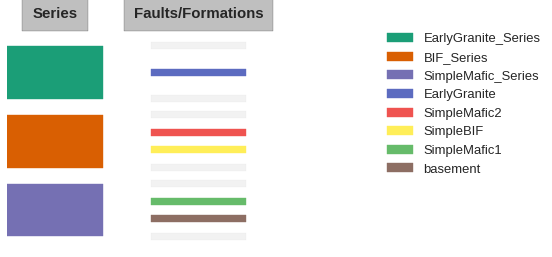

In [3]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                              "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2',
                                         'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

Projection in 2D:

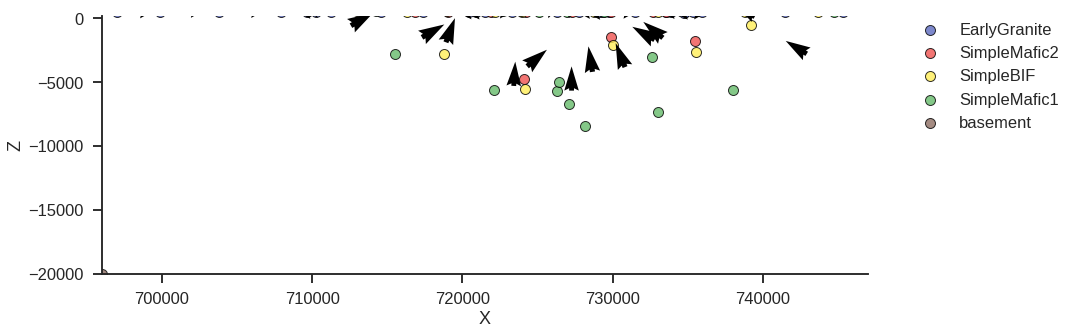

In [4]:
gp.plotting.plot_data(geo_data)

## Computing the model

Now as in the previous chapter we just need to create the interpolator object and compute the model.

In [5]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True)

Compiling theano function...


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4232' (I am process '4317')


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [6]:
lith_block, fault_block = gp.compute_model(interp_data)

/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [7]:
sol =  gp.compute_model(interp_data)

The green rectangle represent the area where we want to compute the forward gravity (in this case is due to this is the area where we have measured data). As we can see the original extent of the geological model is not going to be enough (remember that gravity is affected by a cone, not only the mass right below). An advantage of the method is that we can extrapolate as much as needed keeping in mind that the error will increase accordingly.

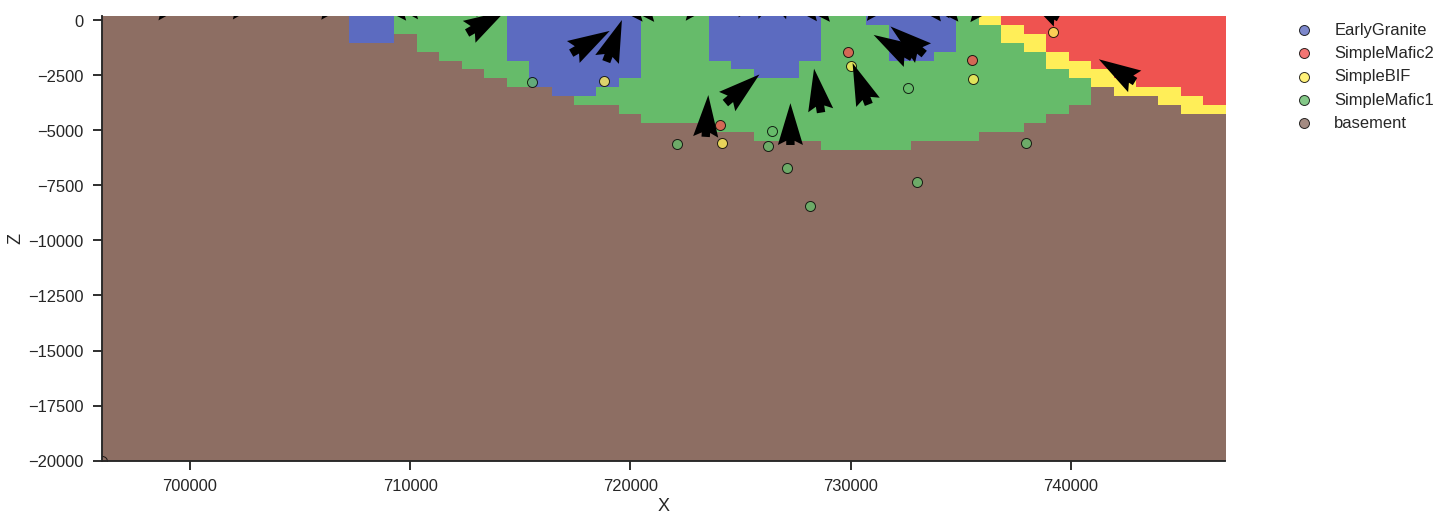

In [8]:
import matplotlib.pyplot as plt

gp.plotting.plot_section(geo_data, lith_block[0], 10, plot_data=True, direction='y')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

from matplotlib.patches import Rectangle

currentAxis = plt.gca()

currentAxis.add_patch(Rectangle((7.050000e+05, 6863000),
                                747000 - 7.050000e+05,
                                6925000 - 6863000,
                      alpha=0.3, fill='none', color ='green' ))

In [9]:
ver_s, sim_s = gp.get_surfaces(interp_data,lith_block[1],
                               None,
                               original_scale=True)

In [10]:
gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver_s, sim_s)

closing vtk


## Gravity computation

So we recalculate all just adding some padding around the measured data (the green rectangle)

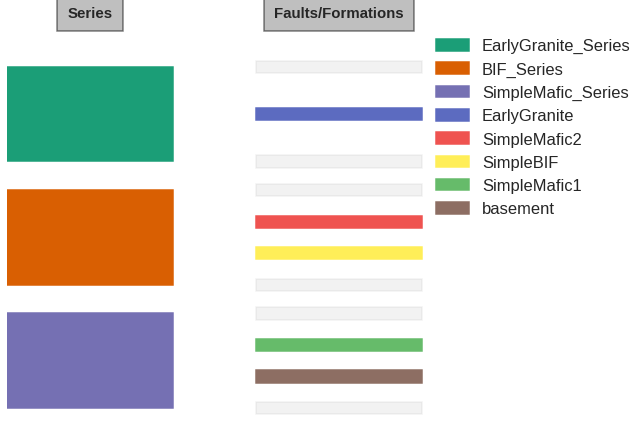

In [11]:
# Importing the data from csv files and settign extent and resolution
geo_data_extended = gp.create_data([696000-10000, 
                                    747000 + 20600, 
                                    6863000 - 20600,6950000 + 20600, 
                                    -20000, 600],
                                   [50, 50, 50],
                         path_o = os.pardir+"/input_data/tut_SandStone/SandStone_Foliations.csv",
                         path_i = os.pardir+"/input_data/tut_SandStone/SandStone_Points.csv")


# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data_extended, {"EarlyGranite_Series": 'EarlyGranite', 
                              "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2', 
                                         'SimpleBIF', 'SimpleMafic1'],
              verbose=1)


In [12]:
geo_data_extended.set_formations(formation_values=[2.61,2.92,3.1,2.92,2.61],
                        formation_order=['EarlyGranite', 'SimpleMafic2',
                                         'SimpleBIF', 'SimpleMafic1',
                                         'basement'])
geo_data_extended.formations

,value,formation_number
EarlyGranite,2.61,1
SimpleMafic2,2.92,2
SimpleBIF,3.10,3
SimpleMafic1,2.92,4
basement,2.61,5


In [13]:
interp_data_grav = gp.InterpolatorData(geo_data_extended,
                    output='gravity', compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


### Z decomposition

In [14]:
gp.set_geophysics_obj(interp_data_grav,
                      [7.050000e+05,747000,6863000,6925000,-20000, 200],
                      [50, 50],)


In [15]:
gp.precomputations_gravity(interp_data_grav, 25);

In [16]:
density_block, fault, grav = gp.compute_model(interp_data_grav, 'gravity')

/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


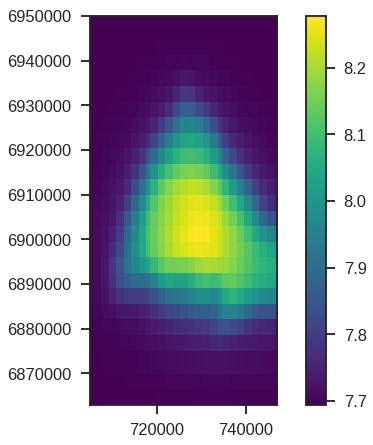

In [17]:
import matplotlib.pyplot as plt

plt.imshow(grav.reshape(50,50), cmap='viridis', origin='lower',
           extent=[7.050000e+05,747000,6863000,6950000] )
plt.colorbar()

## 3D vtk gravity plot (hacking state)

In [18]:
interp_data_ext = gp.InterpolatorData(geo_data_extended,
                    output='geology', compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [19]:
lith_ext, fault_ext = gp.compute_model(interp_data_ext)

In [67]:
import vtkInterface
import numpy as np


#[7.050000e+05,747000,6863000,6925000,-20000, 200

# Lith block grid
grid = vtkInterface.StructuredGrid(
    interp_data_grav.geo_data_res.grid.values[:,0].reshape(50,50,50), 
    interp_data_grav.geo_data_res.grid.values[:,1].reshape(50,50,50), 
    interp_data_grav.geo_data_res.grid.values[:,2].reshape(50,50,50),
                               )
# Fixing lith block direction
e = lith_ext[0].reshape(50,50,50)
g = e.swapaxes(0,2)

# Gravity  mesh
x = np.linspace(7.050000e+05,747000, 50)
y = np.linspace(6863000,6925000, 50)
z = 8000
x, y, z = np.meshgrid(x, y, z)

a = vtkInterface.StructuredGrid(x,y, z)

import copy

col = copy.deepcopy(gp.plotting.colors.cmap)

col.colors = col.colors[1:7]

col.N = 5

col._lut = col._lut[1:10]

plobj = vtkInterface.PlotClass()



plobj.AddMesh(grid, scalars= g,
              showedges=True,
              interpolatebeforemap=False, colormap=col,
              lighting=False)

plobj.AddMesh(a, scalars= grav.reshape(50,50, 1).T,
              showedges=False,
              interpolatebeforemap=False,
              stitle='Forward Gravity',
              colormap='viridis', opacity=0.8)

plobj.Plot(autoclose=True)

[(663259.2012730169, 6736319.112383322, 77534.24959394909),
 (726800.0, 6906500.0, -5897.0),
 (0.36310086158759225, 0.2973360400532743, 0.8830339991188254)]

### 3D plot in matplotlib

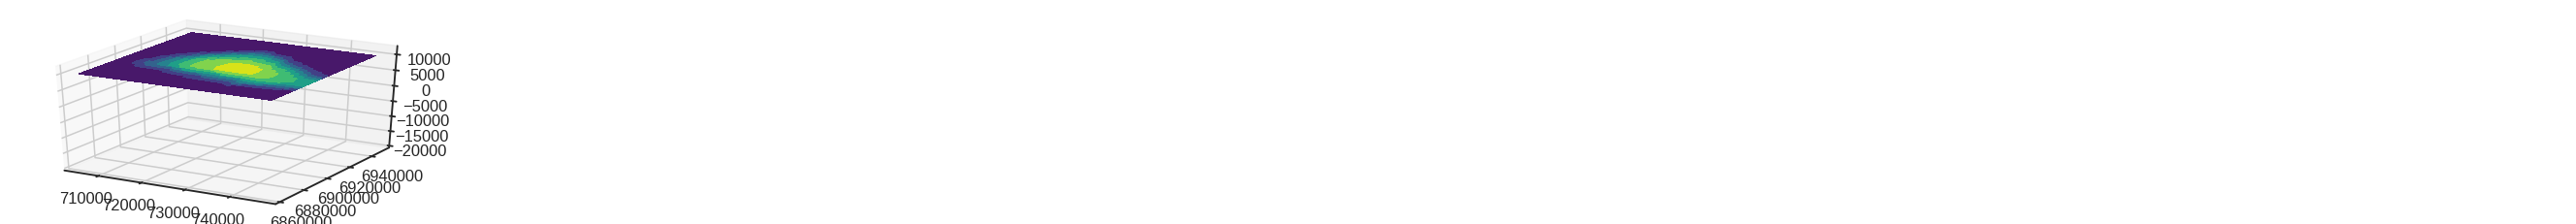

In [22]:
extent = [696000-10000, 
        747000 + 20600, 
        6863000 - 20600,6950000 + 20600, 
        -20000, 600]
                                   
resolution = np.array([51, 51, 51])
g = np.meshgrid(
    np.linspace(extent[0] , extent[1] , resolution[0], dtype="float32"),
    np.linspace(extent[2] , extent[3] , resolution[1], dtype="float32"),
    np.linspace(extent[4] , extent[5] , resolution[2], dtype="float32"), indexing="ij"
)

values = np.vstack(map(np.ravel, g)).T.astype("float32")
values.shape


%matplotlib inline

import matplotlib.pyplot as plt
fig = plt.figure(figsize=plt.figaspect(0.5))
from mpl_toolkits.mplot3d import Axes3D

layer = 3
ax = fig.add_subplot(1, 1, 1, projection='3d')

xx, yy = np.meshgrid(np.linspace(7.050000e+05,747000,50),
                     np.linspace(6863000,6950000,50))



# ax.contourf(xx, yy, grav.reshape(50,50), offset=0, 
#                 cmap='viridis')

# ax.contourf(xx, yy, grav.reshape(50,50), offset=500, 
#                 cmap='viridis')

ax.set_zlim(-20000, 12000)



# ax.voxels(

#           values[:,0].reshape(resolution),
#           values[:,1].reshape(resolution),
#           values[:,2].reshape(resolution), 
#           sol[0][0].reshape(resolution-1) == 1,
#           facecolors = gp.plotting.colors.cmap.colors[1],
#           edgecolor=gp.plotting.colors.cmap.colors[1],
# alpha=.5)

# ax.voxels(

#           values[:,0].reshape(resolution),
#           values[:,1].reshape(resolution),
#           values[:,2].reshape(resolution), 
#           sol[0][0].reshape(resolution-1) == 2,
#         facecolors = gp.plotting.colors.cmap.colors[2],
#           edgecolor=gp.plotting.colors.cmap.colors[2],
# alpha=.5)

# ax.voxels(

#           values[:,0].reshape(resolution),
#           values[:,1].reshape(resolution),
#           values[:,2].reshape(resolution), 
#           sol[0][0].reshape(resolution-1) == 3,
#           facecolors = gp.plotting.colors.cmap.colors[3],
#           edgecolor=gp.plotting.colors.cmap.colors[3],
# alpha=.5)

# ax.voxels(

#           values[:,0].reshape(resolution),
#           values[:,1].reshape(resolution),
#           values[:,2].reshape(resolution), 
#           sol[0][0].reshape(resolution-1) == 4,
#           facecolors = gp.plotting.colors.cmap.colors[4],
#           edgecolor=gp.plotting.colors.cmap.colors[4],
# alpha=.5)

ax.voxels(

          values[:,0].reshape(resolution),
          values[:,1].reshape(resolution),
          values[:,2].reshape(resolution), 
          sol[0][0].reshape(resolution-1) == 5,
          facecolors = gp.plotting.colors.cmap.colors[5],
          edgecolor=gp.plotting.colors.cmap.colors[5],
alpha=.1, zorder=-1);
ax.voxels(

          values[:,0].reshape(resolution),
          values[:,1].reshape(resolution),
          values[:,2].reshape(resolution), 
          sol[0][0].reshape(resolution-1) == 6,
          facecolors = gp.plotting.colors.cmap.colors[6],
          edgecolor=gp.plotting.colors.cmap.colors[6],
alpha=.5);


ax.contourf(xx, yy, grav.reshape(50,50), offset=10000, 
                cmap='viridis', zorder=10)

# # create the figure
# fig = plt.figure()

# # show the reference image
# ax = fig.add_subplot(111, projection='3d')



#ax.auto_scale_xyz(extent[:2], extent[2:4], extent[4:])
